In [20]:
# load_mnist : 라벨 데이터가 저장된 파일과 이미지 데이터가 저장된 파일로부터
# 데이터를 모두 읽어 각각 numpy 배열 labels, images로 저장하여 리턴하는 함수

# 손글씨 데이터를 학습할 다층 퍼셉트론을 파이썬으로 구현

# 포스팅에 제시된 대부분의 소스코드는 Sebatian Raschka의 책 "Python Machine Learning"
# 에서 발퀘한 것이며 제시된 MLP 구현 코드도 이 책에서 발췌하였다.
# 딥러닝 성능을 위해 추가적인 알고리즘이 적용되어 있는 제대로 된
# 다층 퍼셉트론을 구현한 코드입니다.

%matplotlib inline
#import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

# 회귀 분석 - 선형 회귀
from sklearn.linear_model import LinearRegression

#회귀 분석 - 다항 회귀
from sklearn.preprocessing import PolynomialFeatures

# MSE : 평균제곱오차, 작을 수록 오차가 작다.
# R2 : 결정 계수, 1에 가까울 수록 적합도가 좋음 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 회귀 분석 - 의사결정트리/랜덤포레스트
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 교차 검증(Cross Vaildation)
#from sklearn.cross_validation import train_test_split

# k-means 클러스터링
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from matplotlib import cm

# 계층적 클러스터링
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage # 응집형(Agglomerative)
from scipy.cluster.hierarchy import dendrogram # 응집형(Agglomerative) 
from sklearn.cluster import AgglomerativeClustering # 응집형(Agglomerative) 

# 밀도기반 클러스터링 - DBSCAN
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

# 딥러닝 - MNIST 데이터
# MNIST 데이터 : 다양한 사람들이 직접 쓴 숫자 0~9까지의 이미지 집합
import os        # [M32] 용도 확인
import struct

# 딥러닝 - 다층 퍼셉트론
import sys
from scipy.special import expit


style.use('seaborn-talk')

krfont = {'family':'HYGothic-Medium', 'weight':'bold', 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False


def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' %kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' %kind)
    
    with open(labels_path, 'rb') as lbpath:
        # imgpath 파일에서 8바이트 데이터를 big-endian(>)으로 읽고,
        # 읽은 데이터를 unsigned integer(I) 2개로 나누어서 
        # 각각 magic, n 변수에 대입하라는 뜻입니다.
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels


X_train, y_train = load_mnist('./data/mnist', kind='train')
print('학습 샘플수\t:%d, 컬럼수: %d' %(X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('./data/mnist', kind='t10k')
print('테스트 샘플수\t:%d, 컬럼수: %d' %(X_test.shape[0], X_test.shape[1]))


학습 샘플수	:60000, 컬럼수: 784
테스트 샘플수	:10000, 컬럼수: 784


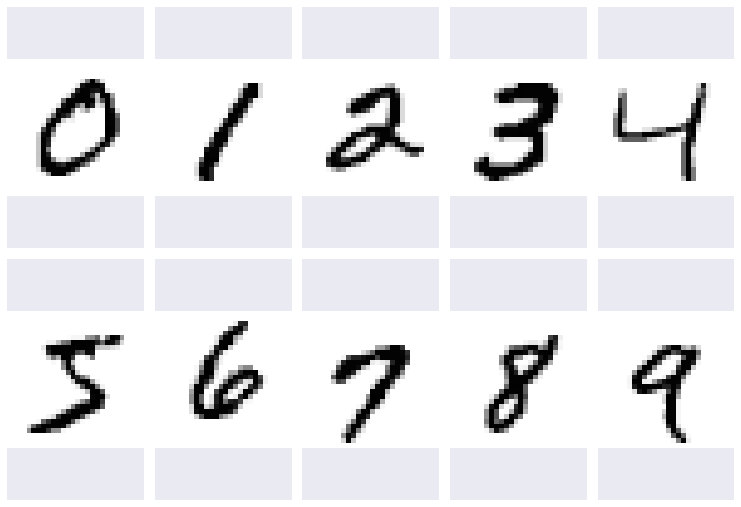

In [26]:
# X_train에 저장된 0~9까지 이미지를 화면에 출력하는 코드

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.ravel()

for i in range(10):
    img = X_train[y_train==i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


학습 샘플수	:60000, 컬럼수: 784
(60000, 784)


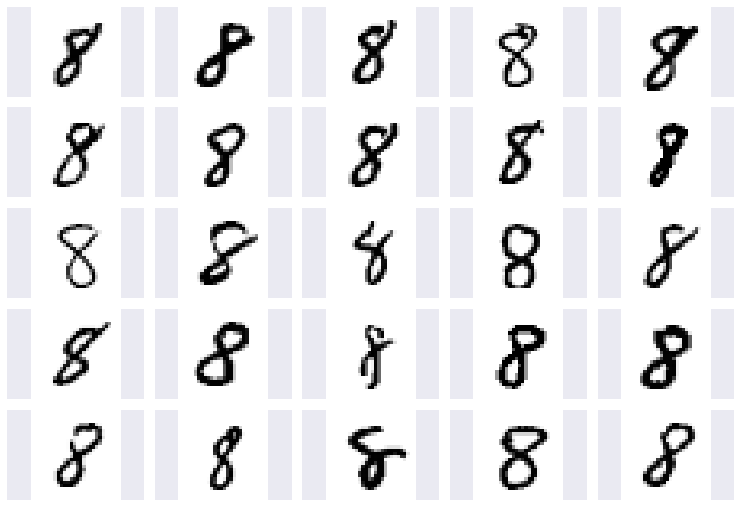

In [27]:
# 위 코드를 약간 수정해서 같은 숫자 25개에 대한 이미지를
# 출력하는 코드

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.ravel()

print('학습 샘플수\t:%d, 컬럼수: %d' %(X_train.shape[0], X_train.shape[1]))
print(X_train.shape)
for i in range(25):
    img = X_train[y_train==8][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# 이로써 우리가 확보한 MNIST 손글씨 데이터가 어떤 식으로 되어있는지
# 확인하였다.

In [58]:

class NeuralNetMLP(object):
     """ Feedforward neural network / Multi-layer perceptron classifier.
    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
        출력층의 출력값 개수.
        손글씨 숫자의 경우 0~9까지 10으로 지정하면 됨.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
        입력층에 입력되는 특성값의 개수.
        28x28 픽셀의 이미지 데이터이므로 784로 지정하면 됨.
    n_hidden : int (default: 30)
        Number of hidden units.
        은닉층의 노드 개수.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
        L1 정규화(regularization)을 위한 람다값.
        오버피팅 방지를 위한 것
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
        L2 정규화(regularization)을 위한 람다값.
        오버피팅 방지를 위한 것
    epochs : int (default: 500)
        Number of passes over the training set.
        학습 반복 회수
    eta : float (default: 0.001)
        Learning rate.
        에타
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
        가중치 업데이트를 보다 고속으로 처리하기 위한 모멘텀 학습 파라메터
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
        학습 수렴률을 향상시키기 위해 learning rate를 학습 반복에 따라 감소시키기
        위한 감쇠 상수
        처음에는 learning rate를 다소 큰 값으로 잡아 최소값에 빨리 다다르게 한 후,
        감쇠 상수를 지속적으로 곱해서 learning rate를 점점 작아지게 할 용도로 사용됨
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
        매 반복마다 트레이닝 데이터를 뒤섞기 위한 플래그.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
        매 학습에 사용되는 무작위로 추출할 트레이닝 데이터의 실제 개수.
        확률적 경사하강법 적용 개념임
        모집단에서 일정 크기의 표본을 추출하여 결과를 통계적으로 예측하는 것과 비슷한 개념
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.
    """
    def __init__(self, n_output, n_features, n_hidden=30, l1=0.0, l2=0.0,
                epochs=500, eta=0.001, alpha=0.0, decrease_const=0.0, shuffle=True,
                minibatches=1, random_state=None):
        
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    # 아래 각 함수는 머신러닝 스터디 사이트와 원본 코드의 주석을 참조할 것    
    
    # 출력층 10개 노드에서 출력되는 값이 (1,0,...0)이면 0, (0,1,0....0)이면 1,
    # (0,0,0.....1)이면 9를 의미하는 것으로 정의함
    # y는 손글씨 숫자의 라벨링 데이터, k는 출력층의 출력값 개수
    def _encode_labels(self, y, k): # y는 실제값, k는 출력층의 노드 개수
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
            
        return onehot
    
    # 입력층과 은닉층 사이의 가중치 w1과 은닉층과 출력층 사이의 가중치 w2의
    # 값을 초기화함.
    # 바이어스 항도 포함시킴
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, 
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, 
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        
        return w1, w2
    
    # z에 대한 시그모이드 합수값을 리턴함. scipy.expit()은 시그모이드 함수임
    def _sigmoid(self, z):
        return expit(z)
    
    # z에 대한 시그모이드 함수의 미분값을 리턴함
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg*(1-sg)
    
    # X에 바이어스 값을 추가해서 X_new로 둠.
    # 행렬 계산의 특성상 입력층에서 은닉층, 은닉층에서 출력층으로의 계산을 위해
    # how 값을 'column', 'row'로 지정하여 바비어스를 행에 더하거나, 열에 더하도록 함.
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('"how" must be "column" or "row"')
            
        return X_new
    
    # 순전파 알고리즘
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        
        return a1, z2, a2, z3, a3
    
    # 정규화 값 리턴
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
    
    # 정규화 값 리턴
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())
    
    # 로지스틱 비용함수 J를 리턴함. J에는 정규화를 위한 값이 추가되었음
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        
        return cost
    
    # 역전파 알고리즘
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        delta3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        delta2 = w2.T.dot(delta3) * self._sigmoid_gradient(z2)
        delta2 = delta2[1:, :]
        grad1 = delta2.dot(a1)
        grad2 = delta3.dot(a2.T)
        
        #정규화
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        
        return grad1, grad2
    
    # X에 대한 예측값을 리턴
    def predict(self, X):
        
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')
        
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        
        return y_pred
    
    # 트레이닝 데이터 X, y를 이용해 다층 퍼셉트론을 학습시킴.
    # 학습 속도를 위해 minibatches로 지정된 개수만큼
    # 데이터를 무작위로 추출하여 학습을 시킨다.
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        
        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            
            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
                
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]
                
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            
            for idx in mini:
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3,
                                     w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                
                # 역전파를 통해 가중치 업데이트를 위한 미분값 계산
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2,
                                                 y_enc=y_enc[:, idx],
                                                 w1=self.w1, w2=self.w2)
                
                # 가중치 업데이트
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
                
        return self


In [61]:
# 784-50-10 다층 퍼셉트론을 구성하고 50개의 데이터를 무작위로 추출한 후
# 1000번 반복 학습을 수행하는 코드

# 한번 실행 후 데이터가 갱신될 때 까진 다시 실행할 필요는 없다.

import pickle

mlp = NeuralNetMLP(n_output=10, 
                   n_features=X_train.shape[1], 
                   n_hidden=50, 
                   l2=0.1, 
                   l1=0.0,
                   epochs=1000, 
                   eta=0.001, 
                   alpha=0.001, 
                   decrease_const=0.00001, 
                   minibatches=50, 
                   shuffle=True, 
                   random_state=1)

mlp.fit(X_train, y_train, print_progress=True)

with open(os.path.join('./data/mnist', 'mlp_digits.pkl'), 'wb') as f:
    pickle.dump(mlp, f, protocol=4)
    
print('머신러닝 데이터 저장 완료')

Epoch: 1000/1000

머신러닝 데이터 저장 완료


In [23]:
# 위 학습 코드 실행 후 생성된 머신러닝 데이터를 로드하는 코드

import pickle

with open(os.path.join('./data/mnist', 'mlp_digits.pkl'), 'rb') as f:
    mlp = pickle.load(f)
    
print('딥러닝 데이터 로드 완료')


딥러닝 데이터 로드 완료


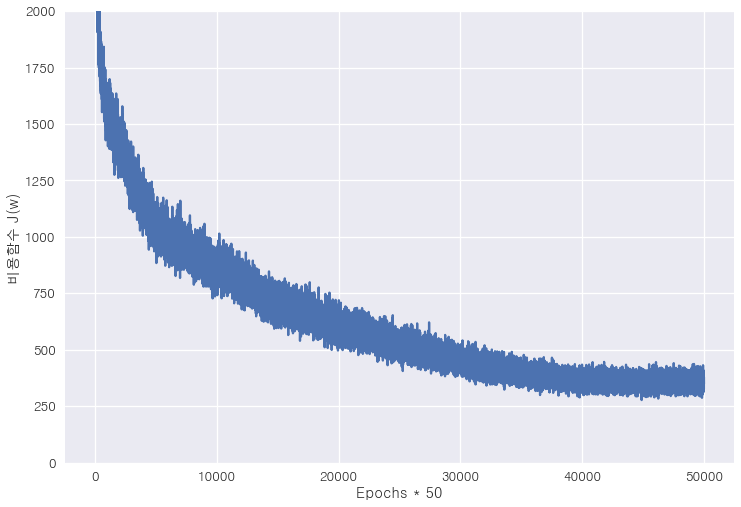

In [63]:
# 비용함수 J가 변화하는 그래프를 시각적으로 확인하는 코드

plt.plot(range(len(mlp.cost_)), mlp.cost_)
plt.ylim([0, 2000])
plt.ylabel('비용함수 J(w)')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()


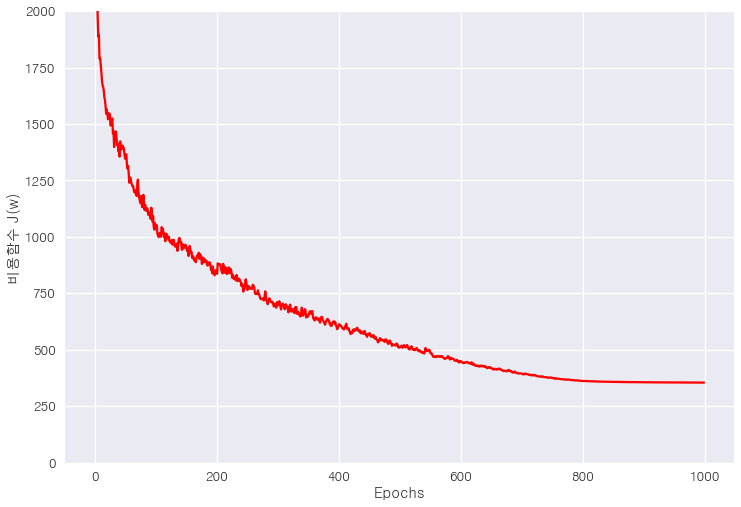

In [65]:

batches = np.array_split(range(len(mlp.cost_)), 1000)
cost_ary = np.array(mlp.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('비용함수 J(w)')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


In [66]:

y_train_pred = mlp.predict(X_train)
success = np.sum(y_train == y_train_pred, axis=0)
total = X_train.shape[0]
accuracy = success/total

print('예측성공/총개수: [%d]/[%d]' %(success, total))
print('딥러닝 정확도: %.2f%%' %(accuracy*100))


예측성공/총개수: [58614]/[60000]
딥러닝 정확도: 97.69%


In [69]:

y_test_pred = mlp.predict(X_test)
success = np.sum(y_test == y_test_pred, axis=0)
total = X_test.shape[0]
accuracy = success/total

print('예측성공/총개수: [%d]/[%d]' %(success, total))
print('딥러닝 정확도: %.2f%%' %(accuracy*100))

# 2개의 결과를 비교해보면 테스트 데이터에 대한 정확도가
# 트레이닝 데이터에 대한 정확도보다 조금 작습니다.
# 이는 학습 결과가 약간 오버피팅이 되었음을 알 수 있습니다.

예측성공/총개수: [9579]/[10000]
딥러닝 정확도: 95.79%


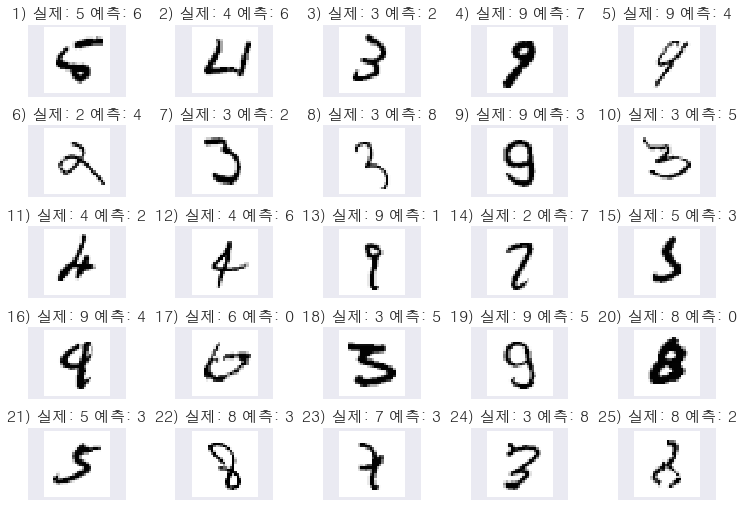

In [70]:

miscl_img = X_test[y_test != y_test_pred][:25]
correct_digit = y_test[y_test != y_test_pred][:25]
miscl_digit = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.ravel()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) 실제: %d 예측: %d' % (i+1, correct_digit[i], miscl_digit[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.savefig('./data/mnist/figures/mnist_miscl.png', dpi=300)
plt.show()
